In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.linalg import qr, pinv
from scipy.linalg import solve_triangular


np.random.seed(42)

# LOESS
Рассмотрим обыкновенную линейную регрессию. ЕЕ формула:
\begin{equation}
y_i = f(x_i) + \epsilon_i,
\end{equation}
где
\begin{equation}
f(x_i) = \beta_0 + \beta_1 \cdot x_i
\end{equation}

Однако рассмотрим данные следующего вида:

In [15]:
x = np.linspace(-15, 15, 300)
y = np.sin(x) + np.random.normal(0, 0.2, 300)

<Axes: >

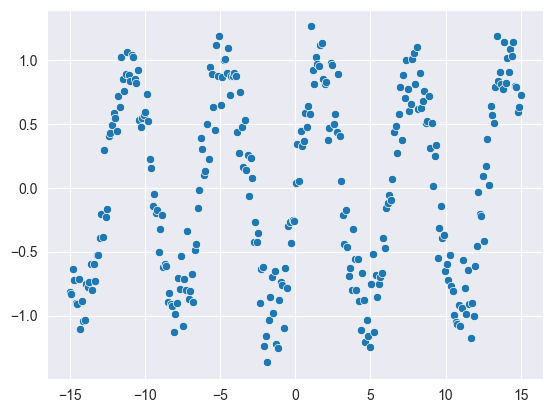

In [16]:
sns.scatterplot(x=x, y=y)

Попробуем обучить модель линейной модели на этих данных

<Axes: >

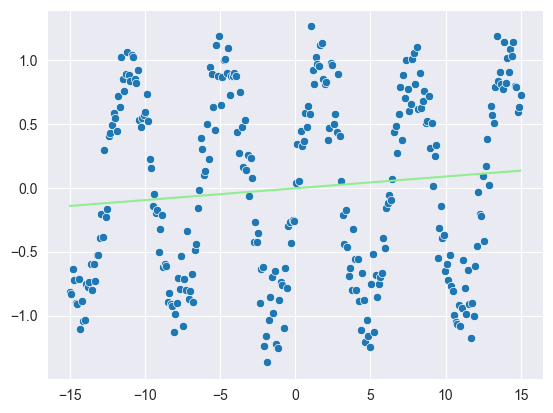

In [20]:
#Обучите линейную модель и постройте графики

Кажется, что линейная модель никак не может выявить зависимость в данных. Одно из возможных решений - полиномиальная регрессия. Как думаете, какая степень полинома понадобится?

<Axes: >

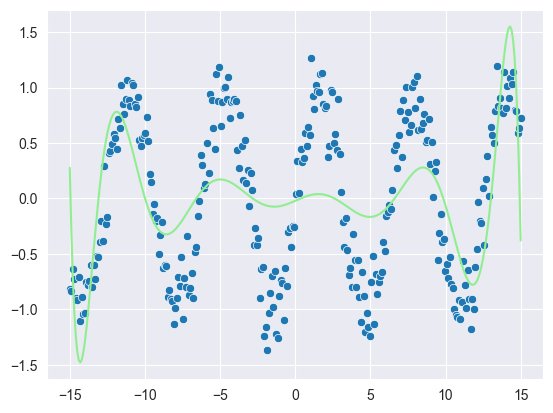

In [36]:
# обавьте полиномиальные фичи и снова обучите модель

Кажется, что для таких данных построить единую модель будет чрезвычайно сложно. Как можно решить такую проблему? Одно из решений - каким-то образом взвесить семплы, чтобы семплы ближе к переломам были более важны.

<Axes: >

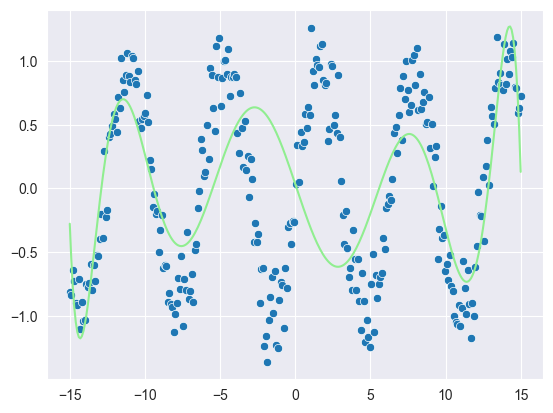

In [42]:
#Обучите с более высокой степенью

Выглядит уже ближе. Однако как бы нам сделать процесс взвешивания автоматическим? Рассмотрим модель взвешенной регрессии

\begin{equation}
f(x_i) = w_i(x_0) \cdot [\beta_0 + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2 + \dots]
\end{equation}

1. Обозначим через $x_i$ набор n значений для конкретной переменной и пусть $y_i$ представляет соответствующие целевые значения.

2. Найдем ближайшие точки к целевой точке $x_0$. Обозначим это множество $D_0$. (Важно учесть расстояния до них: $d_{i0}$).
3. Найдем самое большое расстояние между этими точками. Обозначим эту величину $\delta(x_0)$

4. Вычислим весовую функцию $w_i$ для каждого $x_i \in D_0 $,  используя следующее соотношение:
\begin{equation}
w_i(x_0) = W(\frac{d_{i0}}{\delta(x_0)})
\end{equation},
где:
\begin{equation}
    W(u) =
    \begin{cases}
      (1 - u^3)^3, & 0 \leq u < 1 \\
      0, & \text{otherwise}
    \end{cases}
\end{equation}

5. Рассчитаем финальные веса регрессии $\hat f(x_0)$
 для $x_0$, используя вычисленные веса:
\begin{equation}
\begin{align}

WX\hat \beta &= Wy \\
X'WX\hat \beta &= X'Wy \\
\hat \beta &= (X'WX)^{-1}X'Wy

\end{align}
\end{equation}

LOESS сочетает в себе простоту линейной регрессии наименьших квадратов с гибкостью нелинейной регрессии. Как и в случае с ближайшими соседями, для LOESS нужны все обучающие данные каждый раз, когда мы хотим вычислить прогноз.

Однако как определить, какие точки использовать для подгонки весов? За это отвечает параметр $bandwith$. Этот параметр играет роль, подобную параметру $\gamma$ в сглаживании сплайнов: контролирует гибкость нелинейной подгонки. Чем меньше полоса пропускания, тем более локальным и волнистым будет сглаживание; очень большой диапазон приведет к глобальной подгонке данных с использованием всех обучающих наблюдений. Вопрос: В случае трикубического окна к какому решению будет стремиться подгон при устремлении $bandwith$ к бесконечности?

Так, можно задать полосу пропускания (bandwith) как отступ по x, тогда в нее попадут все x, такие что: $| x_i - x| < h$. Какие минусы такого способа задания окна?

Другой способ - задать ее числом соседей, которые будут использоваться для расчетов. Мы будем использовать именно его.



Реализуем метод локальной регрессии. Это придется делать в несколько этапов. Так, нам необходимо решить уравнение
\begin{equation}
\begin{align}

WX\hat \beta &= Wy \\

\end{align}
\end{equation}

In [200]:
def solve(x, y, W, deg: int = 1):

    A = np.vander(x, N=1+deg) # |  X^2 |X | X^0 ... - we construct polynomial features from x

    # x is horizontal, since we need to transpose it to get solution
    V = # (X^T W)^T X
    Y = # ( X^T W ) y
    Q, R = qr(V)  # make triangular from matrix to get easier solution -> (X^T W)^T X = QR -> final equation: R beta = Q^T * ( X^T W ) y makes
    p = solve_triangular(R, np.matmul(Q.T, Y)) # helps to solve equation with triangular left matrix
    return p


Напишем такую функциюб задающую нашу полосу пропускания и определяющие, кто туда попал:


In [186]:
def get_span(x: np.array, y: np.array, x_target: float, k: int) -> tuple[np.typing.NDArray, np.typing.NDArray, np.typing.NDArray]:
    """ Returns distances, x in span and y in span.
     x is all the x, x_targte - target x, k - number of neighbours to use
     """
    # get list of distances
    distance = #
    # get sorted distances and corresponding indices (using, for example, np.sort + np.argsort)
    sorted_dist = #
    ind = #

    ind_span = ind[:k]
    # we need to use x-s and y-s later in the code, so get them too
    x_span = #
    y_span = #
    # which distance is the lowest?
    delta_0 = #
    # get normalized distances
    u = distance[ind_span] / delta_0
    return u, x_span, y_span

In [194]:
def loess_tricub(x, y, k, deg):

    y_hat = np.zeros(len(x))
    x_space = np.zeros_like(x)

    for i, x_target in enumerate(x):
        # get span
        w = # calculate [w_i] for span

        W = # make W diagonal
        p = # solve equation
        y_hat[i] = np.polyval(p, x_target)
        x_space[i] = x_target

    return y_hat, x_space


Построим график предсказаний. При этом проанимируем то, как строятся предсказания для разных k.

error =  0.016656332175586423


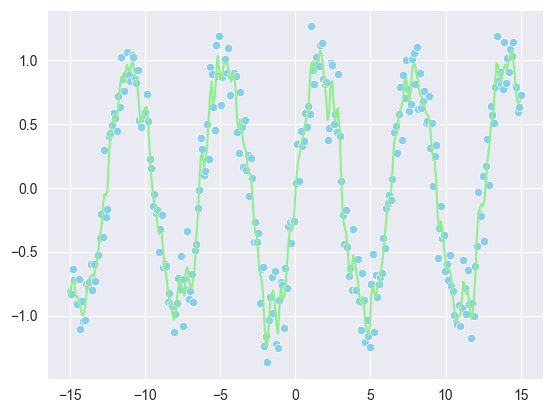

In [195]:
# make loess regression with small k and plots

error =  0.035793064775774076


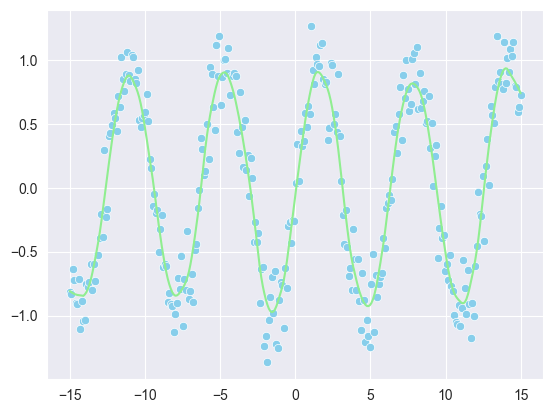

In [197]:
# make loess regression with bigger k and plots

Чем больше k, тем более сглаженным получается решение. Однако какое k выбрать? Как сделать так, чтобы для датасетов разного размера k было разумным? Можно, например, использовать пропорцию от размера датасета. Реализуем это.

In [198]:
def get_k_relative(alpha: float, n: int):
    return # create size-adaptive bandwidth

def loess_tricub_alpha(x, y, alpha, deg):
    # your code
    return y_hat, x_space


error =  0.035793064775774076


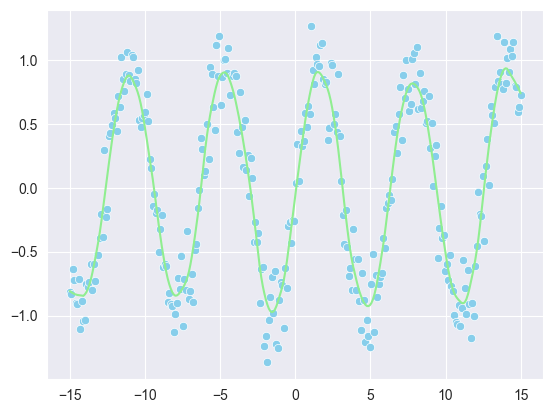

In [199]:
# make regression and plots

Можно ли использовать другие функции в качестве весовых? Да, например, воспользуемся колоковидным ядром:
\begin{equation}
w^{(i)}  = \exp \left( - \frac{(x^{(i)} - x)^2}{2 \tau^2} \right)
\end{equation}
Параметр $\tau$ контролирует, насколько быстро вес обучающего примера падает с увеличением расстояния до точки x
 и называется параметром _bandwidth_. Вопрос: Как меняется форма колококола при увеличении  $\tau$?

Вопрос: Является ли это ядро гауссовым?

In [263]:
def loess(x, y, kernel, alpha, deg, **kernel_params):
    # Your code
    return x_space, y_pred

In [203]:
def tricub_kernel(dist):
    return # make tricub kernel for calculated distances

def bell_kernel(dist, tau):
    return  # make bell kernel for calculated distances


error =  0.035793064775774076


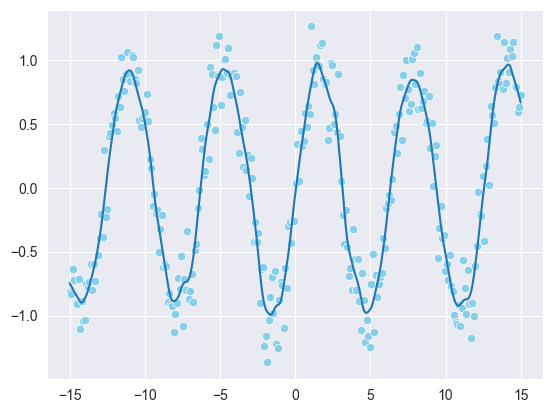

In [204]:
# calculate tricub loess with kernel as parameter

error =  0.02679153940295601


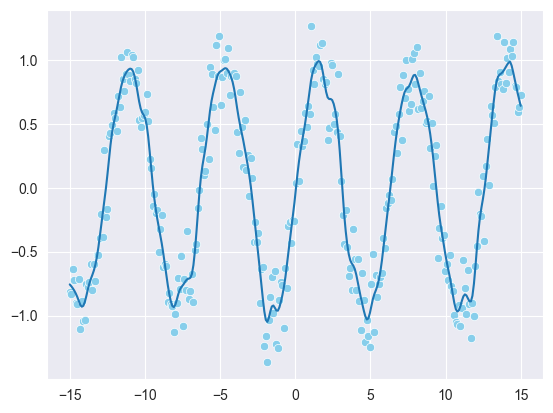

In [205]:
tau = 0.3
#make loess with bell kernel

Раз $tau$ регулирует, какой вклад будут давать дальние элементы, чего не было в обычном трикубическом ядре, нужен ли нам теперь параметр $\alpha$?

error =  0.026823963566419955


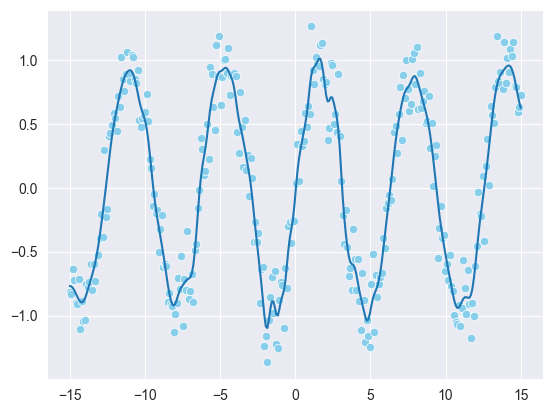

In [165]:
# set a as 1. and find tau which gives similar results

Если ошибки имеют симметричное распределение (с длинными хвостами) или есть выбросы, мы можем использовать более робастный LOESS.
Определим остатки:
\begin{equation}
r_i = y_i - f (x_i)
\end{equation}
Используем базовое ядро, заданное биквадратной фкнкцией:
\begin{equation}
    B(u, b) =
    \begin{cases}
      (1 - u^2)^2, & 0 \leq u < 1 \\
      0, & \text{otherwise}
    \end{cases}
\end{equation}
Пусть $m(r) = median(|r|)$. Дополнительные веса тогда:
\begin{equation}
\gamma_i = B(r_i, 6m)
\end{equation}

Финальные веса принимают вид $\tilde {w_i } = gamma_i * w_i.



In [248]:
def bicubic_kernel(dist):
    return # create bicubic kernel

def get_robust_weights(y, y_pred):
    residuals = #
    s = #
    multiplier = # get weights # we clip to preserve final results bounds
    return multiplier

In [261]:
def loess_robust(x, y, kernel, alpha, deg, iterations, **kernel_params):
    k = get_k_relative(alpha=alpha, n=len(x))
    y_pred = np.zeros(len(x))
    x_space = np.zeros_like(x)
    r_weights = np.ones(len(x))
    for iter in range(iterations):
        # get loess weights
        r_weights = get_robust_weights(y, y_pred)

    return x_space, y_pred

In [258]:
x = np.linspace(-15, 15, 300)
y = np.sin(x) + np.random.normal(0, 0.2, 300)
y[5:10] -= 0.7
y[45:50] += 1.1
y[-30] += 1.
x[-45:-40] -= 0.1

x[45] += 1.1

In [260]:
x_est_naive , y_est_naive = loess(x, y, kernel=bell_kernel, alpha=0.05, deg=1, tau=tau)


[-6.14673583e-01 -6.77926756e-01 -7.42939225e-01 -8.08406906e-01
 -8.72066160e-01 -9.30154642e-01 -9.76562582e-01 -1.00161270e+00
 -9.80257715e-01 -9.42408056e-01 -9.02931301e-01 -8.69819523e-01
 -8.41374803e-01 -8.14375181e-01 -7.87779658e-01 -7.51642255e-01
 -7.05775695e-01 -6.50509447e-01 -5.87125669e-01 -5.12017798e-01
 -4.26765366e-01 -3.35637295e-01 -2.42322147e-01 -1.48332184e-01
 -5.75185215e-02  3.08450796e-02  1.16933881e-01  2.01133521e-01
  2.88533669e-01  3.80900702e-01  4.68589878e-01  5.48130797e-01
  6.13484560e-01  6.63575910e-01  6.99573815e-01  7.31859293e-01
  7.67156708e-01  8.09626224e-01  8.57879380e-01  9.11078961e-01
  9.59985876e-01  9.97493500e-01  1.01619293e+00  1.01105786e+00
  9.84840634e-01  9.40171363e-01  8.82919881e-01  8.20309669e-01
  7.51040551e-01  6.74915390e-01  5.87020990e-01  4.88636974e-01
  3.85548882e-01  2.80560865e-01  1.75565327e-01  7.04432824e-02
 -3.99186364e-02 -1.54259059e-01 -2.68683681e-01 -3.76466606e-01
 -4.71242640e-01 -5.53208

--
[-0.75285498 -0.83833818 -0.92826336 -1.02187473 -1.11742088 -1.21122929
 -1.29585327 -1.3565106  -1.33047734 -1.27009525 -1.18839693 -1.10152858
 -1.01898701 -0.94023813 -0.870471   -0.80551806 -0.73906187 -0.67590686
 -0.61071431 -0.53179208 -0.43924209 -0.33522406 -0.2242511  -0.11562525
 -0.00994662  0.08786384  0.18537209  0.28220622  0.38056058  0.48066068
  0.57587108  0.66107026  0.73682963  0.79968889  0.84608908  0.87800145
  0.8973361   0.90795291  0.90899619  0.92612839  0.95442227  0.99278889
  1.05306242  1.10230859  1.1701556   0.33792689  1.22865234  1.21784202
  1.16928001  1.09736791  0.94502707  0.79451353  0.66858254  0.57131359
  0.49445881  0.41546187  0.33080566  0.22529906  0.09783725 -0.03987653
 -0.17658225 -0.30696575 -0.43124032 -0.55544296 -0.65089479 -0.73861081
 -0.81657939 -0.88315702 -0.93536528 -0.96968531 -0.98568054 -0.98561772
 -0.97191102 -0.95298186 -0.92956083 -0.89806672 -0.8566638  -0.79789309
 -0.72365794 -0.63521977 -0.53775389 -0.43694302

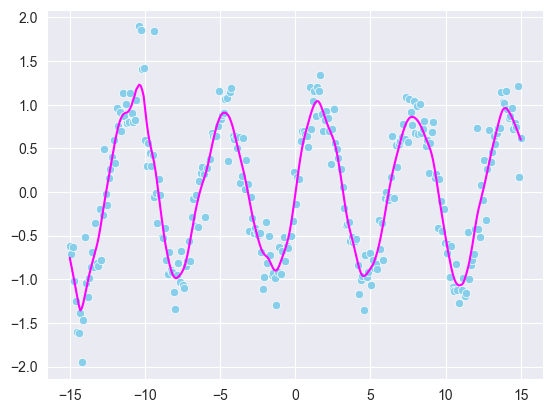

In [257]:
tau = 0.4

x_est, y_est = loess_robust(x, y, kernel=bell_kernel, alpha=0.05, deg=1, iterations=5, tau=tau)
sns.lineplot(x=x_est, y=y_est, color="magenta")

sns.scatterplot(x=x, y=y, color ='skyblue')

print("error = ", mean_squared_error(y_true=y, y_pred=y_est))

Как видно, все ядра, которые мы использовали ранее, давали меньшие значения при увеличении расстояния. Однако есть ядро, которое использует равномерное распределение. Давайте его реализуем.


Какому методу эквивалентно использование этого ядра?

Рассмотрим и уже знакомую нам задачу предсказания стоимости.

In [282]:
data_path = "D:\data\machine_learning"
data = pd.read_csv(f"{data_path}/realestate.txt", sep="\t")

data = data[["SalePrice", "SqFeet", "Lot"]]
data = np.log(data)
X_train, X_test, y_train, y_test = train_test_split(data[["SqFeet"]], data["SalePrice"])

model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_train)
loess_x, loess_y = loess_robust(X_train.values.astype(float).ravel(), y_train.values.astype(float).ravel(), kernel=bell_kernel, alpha=0.05, deg=1, iterations=5, tau=tau)
loess_x_naive , loess_y_naive = loess(X_train.values.astype(float).ravel(), y_train.values.astype(float).ravel(), kernel=bell_kernel, alpha=0.05, deg=1, tau=tau)


--
--
Linear Regression error:  0.05158258210024667
loess error =  0.042279391175254685


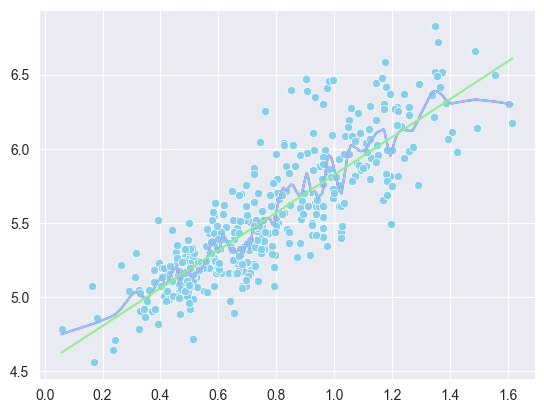

In [283]:
tau = 0.4

print('--')
sns.lineplot(x=loess_x, y=loess_y , color="magenta")
print('--')
sns.lineplot(x=loess_x_naive, y= loess_y_naive , color ='skyblue')
sns.lineplot(x=X_train.values.astype(float).ravel(), y= preds.ravel() , color ='lightgreen')
sns.scatterplot(x=X_train.values.astype(float).ravel(), y=y_train.values.astype(float).ravel() , color ='skyblue')
print("Linear Regression error: ", mean_squared_error(y_true=y_train.values.astype(float).ravel(), y_pred=preds))
print("loess error = ", mean_squared_error(y_true=y_train.values.astype(float).ravel(), y_pred=loess_y_naive))